In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
from collections import Counter, defaultdict
import re
import string
import emoji
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [3]:
raw_train_ta_data = pd.read_csv(sys.path[-1] + '/raw_data/ta-misogyny-train.csv', sep='\t', header=None)
raw_dev_ta_data = pd.read_csv(sys.path[-1] + '/raw_data/ta-misogyny-dev.csv', sep='\t', header=None)
raw_train_ta_en_data = pd.read_csv(sys.path[-1] + '/raw_data/ta-en-misogyny-train.csv', sep='\t', header=None)
raw_dev_ta_en_data = pd.read_csv(sys.path[-1] + '/raw_data/ta-en-misogyny-dev.csv', sep='\t', header=None)

## 1.查看DataFrame中是否有缺失值

In [4]:
def judge_nan_and_display(df):
    if df[1].isna().any():
        return True, df[df.isna().values == True]
    else:
        return False

In [5]:
judge_nan_and_display(raw_train_ta_data)

False

In [6]:
judge_nan_and_display(raw_dev_ta_data)

False

In [7]:
judge_nan_and_display(raw_train_ta_en_data)

(True,
                       0    1
 27    None-of-the-above  NaN
 730   None-of-the-above  NaN
 3829  None-of-the-above  NaN
 5027  None-of-the-above  NaN
 5874  None-of-the-above  NaN)

In [8]:
judge_nan_and_display(raw_dev_ta_en_data)

(True,
                      0    1
 692  None-of-the-above  NaN
 811  None-of-the-above  NaN)

In [9]:
# 不需要做填充, 直接把NaN的行删掉
drop_nan_row = lambda df: df.drop(df[df.isna().values==True].index)
raw_train_ta_en_data = drop_nan_row(raw_train_ta_en_data)
raw_dev_ta_en_data = drop_nan_row(raw_dev_ta_en_data)

## 2.统计各数据集中各类别的分布情况

In [10]:
counter = lambda series: Counter(series).most_common()
counter(raw_train_ta_data[0])

[('None-of-the-above', 1296),
 ('Misandry', 446),
 ('Counter-speech', 149),
 ('Misogyny', 125),
 ('Xenophobia', 95),
 ('Hope-Speech', 86),
 ('Homophobia', 35),
 ('Transphobic', 6),
 ('Not-Tamil', 2)]

In [11]:
counter(raw_dev_ta_data[0])

[('None-of-the-above', 346),
 ('Misandry', 104),
 ('Counter-speech', 36),
 ('Xenophobia', 29),
 ('Misogyny', 24),
 ('Hope-Speech', 11),
 ('Homophobia', 8),
 ('Transphobic', 2)]

In [12]:
counter(raw_train_ta_en_data[0])

[('None-of-the-above', 3715),
 ('Misandry', 830),
 ('Counter-speech', 348),
 ('Xenophobia', 297),
 ('Hope-Speech', 213),
 ('Misogyny', 211),
 ('Homophobia', 172),
 ('Transphobic', 157)]

In [13]:
counter(raw_dev_ta_en_data[0])

[('None-of-the-above', 917),
 ('Misandry', 218),
 ('Counter-speech', 95),
 ('Xenophobia', 70),
 ('Hope-Speech', 53),
 ('Misogyny', 50),
 ('Homophobia', 43),
 ('Transphobic', 40)]

In [14]:
# 就只有 raw_train_ta_data 中是出现了 Not-Tamil 这一标签, 考虑直接给他删掉
raw_train_ta_data = raw_train_ta_data.drop(raw_train_ta_data[raw_train_ta_data[0]=='Not-Tamil'].index)

## 3.设计 Tokenizer, 统计句子长度等信息

In [15]:
def join_elipsis(tokens):
    # 把有多个点换成省略号
    new_tokens = [tokens[0]]
    for i in range(1, len(tokens)):
        if tokens[i] == '.' and '.' in new_tokens[-1]:
            new_tokens[-1] = '......'
        else:
            new_tokens.append(tokens[i])
    return new_tokens

def tokenizer(text):
    # 删除评论中的emoji表情
    text = emoji.get_emoji_regexp().sub(r'', text.encode('utf8').decode('utf8'))
    
    # 为标点前后加上空格
    for x in string.punctuation:
        text = text.replace(x," %s " % x)
    
    # 删除字符串中多余的空格, 并全部小写
    result = ' '.join(text.split()).lower()
    return join_elipsis(result.split())

### 3.1 raw_train_ta_data

In [16]:
raw_train_ta_data['tokens'] = raw_train_ta_data[1].apply(tokenizer)
raw_train_ta_data['ch_count'] = raw_train_ta_data['tokens'].apply(lambda x: len(x))
raw_train_ta_data['tokenstr'] = raw_train_ta_data['tokens'].apply(lambda x: ' '.join(x))

In [18]:
raw_train_ta_data['ch_count'].describe()

count    2238.000000
mean       14.093834
std        16.268592
min         1.000000
25%         6.000000
50%         9.000000
75%        16.000000
max       193.000000
Name: ch_count, dtype: float64

Text(0.5, 0, 'category')

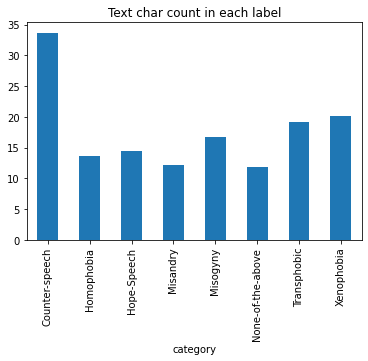

In [19]:
text_len_each_label = raw_train_ta_data.groupby(0).agg('mean','ch_count')['ch_count']
text_len_each_label.plot(kind='bar')
plt.title('Text char count in each label')
plt.xlabel("category")

### 3.2 raw_dev_ta_data

In [20]:
raw_dev_ta_data['tokens'] = raw_dev_ta_data[1].apply(tokenizer)
raw_dev_ta_data['ch_count'] = raw_dev_ta_data['tokens'].apply(lambda x: len(x))
raw_dev_ta_data['tokenstr'] = raw_dev_ta_data['tokens'].apply(lambda x: ' '.join(x))
raw_dev_ta_data['ch_count'].describe()

count    560.000000
mean      13.503571
std       13.443980
min        1.000000
25%        5.000000
50%        9.000000
75%       16.000000
max       89.000000
Name: ch_count, dtype: float64

Text(0.5, 0, 'category')

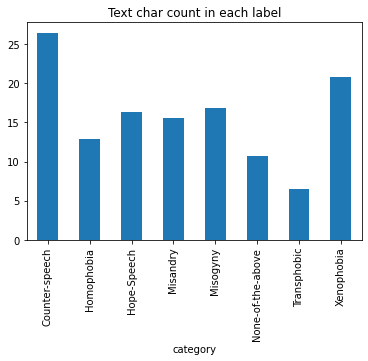

In [21]:
text_len_each_label = raw_dev_ta_data.groupby(0).agg('mean','ch_count')['ch_count']
text_len_each_label.plot(kind='bar')
plt.title('Text char count in each label')
plt.xlabel("category")

### 3.3 raw_train_ta_en_data

In [22]:
raw_train_ta_en_data['tokens'] = raw_train_ta_en_data[1].apply(tokenizer)
raw_train_ta_en_data['ch_count'] = raw_train_ta_en_data['tokens'].apply(lambda x: len(x))
raw_train_ta_en_data['tokenstr'] = raw_train_ta_en_data['tokens'].apply(lambda x: ' '.join(x))
raw_train_ta_en_data['ch_count'].describe()

count    5943.000000
mean       13.303382
std        13.162002
min         2.000000
25%         6.000000
50%         9.000000
75%        15.000000
max       178.000000
Name: ch_count, dtype: float64

Text(0.5, 0, 'category')

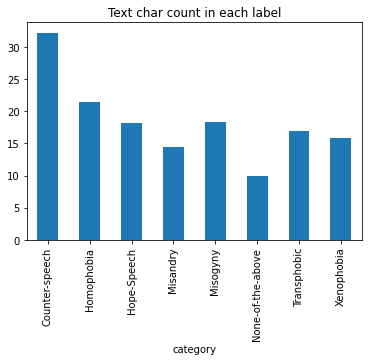

In [23]:
text_len_each_label = raw_train_ta_en_data.groupby(0).agg('mean','ch_count')['ch_count']
text_len_each_label.plot(kind='bar')
plt.title('Text char count in each label')
plt.xlabel("category")

### 3.4 raw_dev_ta_en_data

In [24]:
raw_dev_ta_en_data['tokens'] = raw_dev_ta_en_data[1].apply(tokenizer)
raw_dev_ta_en_data['ch_count'] = raw_dev_ta_en_data['tokens'].apply(lambda x: len(x))
raw_dev_ta_en_data['tokenstr'] = raw_dev_ta_en_data['tokens'].apply(lambda x: ' '.join(x))
raw_dev_ta_en_data['ch_count'].describe()

count    1486.000000
mean       13.386945
std        13.352423
min         3.000000
25%         6.000000
50%         9.000000
75%        15.000000
max       147.000000
Name: ch_count, dtype: float64

Text(0.5, 0, 'category')

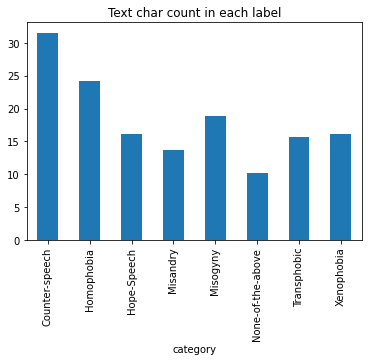

In [25]:
text_len_each_label = raw_dev_ta_en_data.groupby(0).agg('mean','ch_count')['ch_count']
text_len_each_label.plot(kind='bar')
plt.title('Text char count in each label')
plt.xlabel("category")

## 4.统计各数据集中token的数量

In [25]:
def count_tokens(token_lists):
    all_tokens = []
    for token_list in token_lists:
        all_tokens += token_list
    
    return Counter(all_tokens).most_common()

In [26]:
raw_train_ta_token_count = count_tokens(raw_train_ta_data['tokens'])
len(raw_train_ta_token_count)

11018

In [27]:
raw_dev_ta_token_count = count_tokens(raw_dev_ta_data['tokens'])
len(raw_dev_ta_token_count)

3693

In [28]:
raw_train_ta_en_token_count = count_tokens(raw_train_ta_en_data['tokens'])
len(raw_train_ta_en_token_count)

21315

In [29]:
raw_dev_ta_en_token_count = count_tokens(raw_dev_ta_en_data['tokens'])
len(raw_dev_ta_en_token_count)

7694

In [32]:
# 每个训练集中token数量太大, 字典太大, 考虑每个标签单独统计词频, 然后再与 None-of-the-above 整合
# 暂时没用, 因为大部分都还是单个词, 感觉也不太好合并
def count_each_tag_tokens(df, tag):
    df_tag = df[df[0]==tag]
    return dict(count_tokens(df_tag['tokens']))

def combine_freq_dicts(freq_dicts):
    final_freq_dict = defaultdict(int)
    for fd in freq_dicts:
        for k, v in fd.items():
            final_freq_dict[k] += v
    
    return final_freq_dict

def combine_abusive_tags_freq_dicts(df):
    tags = ['Misandry', 'Counter-speech', 'Xenophobia', 'Hope-Speech', 'Misogyny', 'Homophobia', 'Transphobic']
    return combine_freq_dicts([count_each_tag_tokens(df, tag) for tag in tags])

def combine_all_freq_dicts(df):
    abusive_tags_freq_dict = combine_abusive_tags_freq_dicts(df)
    nonabusive_freq_dict = count_each_tag_tokens(df, 'None-of-the-above')
    pass


In [26]:
# 保存简单清洗过的dataframe
raw_train_ta_data.to_csv(sys.path[-1] + '/raw_data/clean-ta-train.csv', header=['tag', 'raw_text', 'tokens', 'ch_count', 'tokenstr'], index=False)
raw_dev_ta_data.to_csv(sys.path[-1] + '/raw_data/clean-ta-dev.csv', header=['tag', 'raw_text', 'tokens', 'ch_count', 'tokenstr'], index=False)
raw_train_ta_en_data.to_csv(sys.path[-1] + '/raw_data/clean-ta-en-train.csv', header=['tag', 'raw_text', 'tokens', 'ch_count', 'tokenstr'], index=False)
raw_dev_ta_en_data.to_csv(sys.path[-1] + '/raw_data/clean-ta-en-dev.csv', header=['tag', 'raw_text', 'tokens', 'ch_count', 'tokenstr'], index=False)